## Define network

In [48]:
import torch
from torch import nn
from src.transformers import ViT, Decoder

torch.manual_seed(0)


class Net(nn.Module):
    def __init__(self, embed_dim=16):
        super(Net, self).__init__()

        self.encoder = ViT(embed_dim=embed_dim, n_blocks=1, n_heads=2)

        self.decoder = Decoder(embed_dim=embed_dim,
                               n_blocks=2, encoder_dim=embed_dim, n_heads=1)

        self.mapper = nn.Linear(3, embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 3),
            nn.Sigmoid()
        )

    def forward(self, x, p, mask=None):
        x = self.encoder(x)
        p = self.mapper(p)
        x = self.decoder(p, x[:, 0, :], mask)
        x = self.mlp(x)

        return x

## Define dataset anda dataloader

In [49]:
from src.datasets import PolyMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

train = PolyMNIST(csv_file="mnist/train/polygon-mnist.csv",
                  transform=ToTensor())

test = PolyMNIST(csv_file="mnist/test/polygon-mnist.csv",
                 transform=ToTensor())

train_loader = DataLoader(train, batch_size=30, shuffle=True)
test_loader = DataLoader(test, batch_size=30, shuffle=False)

## Train

In [54]:
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm.notebook import trange, tqdm
import torch

N_EPOCHS = 5
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(
    device) if torch.cuda.is_available() else "cpu"
print("Using device: ", device, f"({device_name})")

mask = torch.tril(torch.ones(12, 12)).view(1, 12, 12).to(device)

model = Net().to(device)
optimizer = Adam(model.parameters(), lr=LR)
criterion = MSELoss()

model.load_state_dict(torch.load("checkpoints/poly_mask_16emb_001.pth"), strict=True)

train_loss = 0.0
for epoch in trange(N_EPOCHS, desc="Training"):
    model.train()

    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        image, _, polygon = batch

        image = image.to(device)
        polygon = polygon.to(device)

        pred = model(image, polygon, mask)
        loss = criterion(pred[:, :-1, :], polygon[:, 1:, :])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() / len(train_loader)

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f}")

    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        model.eval()
        for batch in tqdm(test_loader, desc="Testing"):
            x, _, p = batch
            x, p = x.to(device), p.to(device)

            pred = model(image, polygon, mask)
            loss = criterion(pred[:, :-1, :], polygon[:, 1:, :])

            test_loss += loss.detach().cpu().item() / len(test_loader)

            # correct += torch.sum(torch.argmax(y_hat, dim=1)
            #                      == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.4f}")
    # print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (NVIDIA GeForce GTX 1050)


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Show

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

def subplot(fig, rows, cols, pos, title, img_tensor, poly_tensor):
    image = img_tensor.cpu().numpy() * 255

    out = np.zeros((28,28, 3))
    out[:,:, 1] = np.copy(image)

    poly_tensor = poly_tensor[1:]
    filter1 = poly_tensor[:, 0] < 1.0
    poly_tensor = poly_tensor[filter1]

    poly = poly_tensor.cpu().numpy()
    poly = np.delete(poly, 0, 1).reshape(-1, 1, 2) * 28
    poly = poly.astype(np.int32)
    
    out = cv2.polylines(out, [poly], True, (255,0,0), 1)

    subplot.counter += 1
    fig.add_subplot(rows, cols, pos)
    plt.imshow(out.astype(np.uint8))
    plt.axis('off')
    plt.title(title)


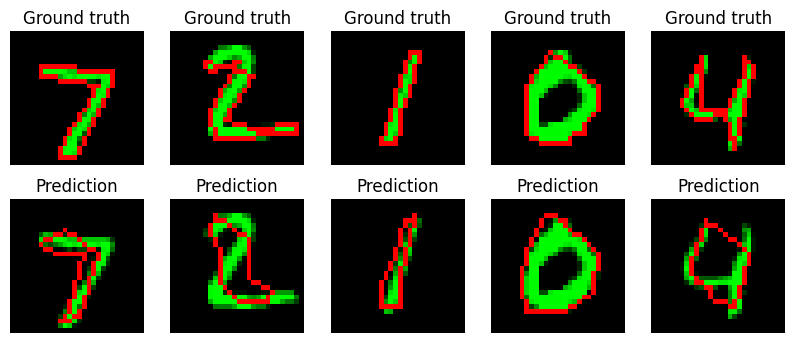

In [ ]:
batch_images, _, poly = next(iter(test_loader))

fig = plt.figure(figsize=(10, 4))
idx_range = 5
subplot.counter = 0

for idx in range(idx_range):
    with torch.no_grad():
        model.eval()
        inputs = torch.zeros(1, 1, 3).to(device)
        image = batch_images[idx].reshape(1, 1, 28, 28).to(device)

        for i in range(11):
            pred = model(image, inputs, mask[:, :i + 1, :i + 1])

            if (pred[0, -1, 0] > 0.95):
                break
            
            inputs = torch.cat((inputs, pred[:, -1, :].view(1, 1, -1)), dim=1)
    pos_gt = idx + 1
    pos_pred = idx + 1 + idx_range
    subplot(fig, 2, idx_range, pos_gt, "Ground truth", batch_images[idx, 0], poly[idx])
    subplot(fig, 2, idx_range, pos_pred, "Prediction", batch_images[idx, 0], inputs[0])

plt.show()


## Save

In [ ]:
path = "checkpoints/poly_mask_16emb_002.pth"
torch.save(model.state_dict(), path)